In [1]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

In [2]:
auth_zip_path = '/content/informate.zip'
unauth_zip_path = '/content/unformate.zip'

# Step 2: Extract the zip files
with zipfile.ZipFile(auth_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/authenticated')

with zipfile.ZipFile(unauth_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unauthenticated')


In [3]:

auth_dir = '/content/authenticated'
unauth_dir = '/content/unauthenticated'

In [4]:

print("Authenticated directory contents:", os.listdir(auth_dir))
print("Unauthenticated directory contents:", os.listdir(unauth_dir))

Authenticated directory contents: ['informate']
Unauthenticated directory contents: ['unformate']


In [5]:

images = []
labels = []


def load_images_from_subfolders(parent_folder, label):
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                img_path = os.path.join(root, file)
                img = load_img(img_path, target_size=(224, 224))
                img = img_to_array(img)
                images.append(img)
                labels.append(label)


load_images_from_subfolders(auth_dir, 1)
load_images_from_subfolders(unauth_dir, 0)
print(f"Number of authenticated images loaded: {labels.count(1)}")
print(f"Number of unauthenticated images loaded: {labels.count(0)}")


Number of authenticated images loaded: 680
Number of unauthenticated images loaded: 679


In [6]:
images = np.array(images)
labels = np.array(labels)

if len(images) == 0:
    raise ValueError("No images were loaded. Check the directories and file formats.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 591ms/step - accuracy: 0.4882 - loss: 0.7215 - val_accuracy: 0.6103 - val_loss: 0.6718
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.6056 - loss: 0.6678 - val_accuracy: 0.7500 - val_loss: 0.6386
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.6121 - loss: 0.6469 - val_accuracy: 0.7684 - val_loss: 0.6108
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.7638 - loss: 0.6048 - val_accuracy: 0.7500 - val_loss: 0.5932
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7648 - loss: 0.5850 - val_accuracy: 0.7941 - val_loss: 0.5656
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.7672 - loss: 0.5760 - val_accuracy: 0.7794 - val_loss: 0.5496
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7817 - loss: 0.5494 - val_accuracy: 0.7757 - val_loss: 0.5378
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 10

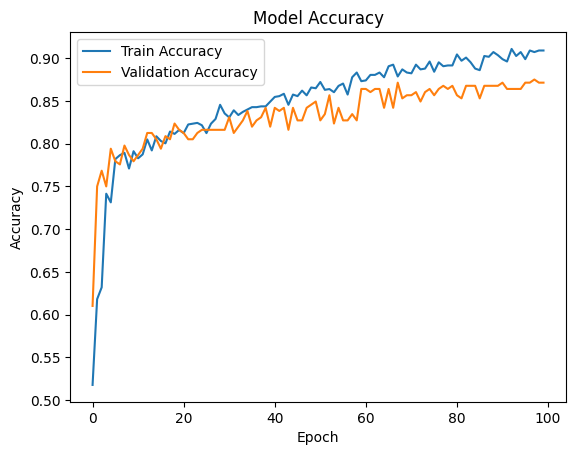

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

model.save('resnet50_authentication_model.h5')

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy:.4f}')


9/9 - 1s - 87ms/step - accuracy: 0.8713 - loss: 0.2932
Test accuracy: 0.8713


In [11]:
# Save model using the native Keras format
model.save('resnet50_authentication_model.keras')


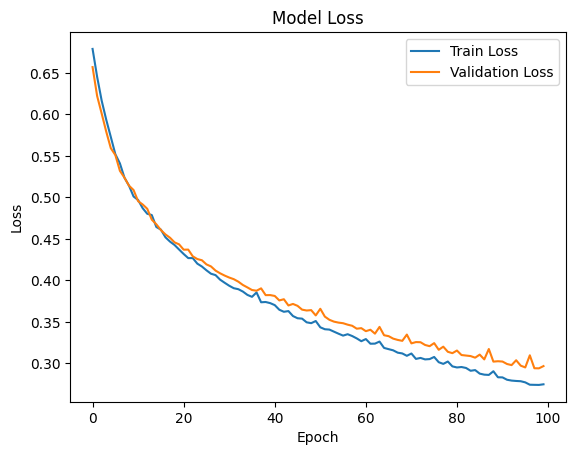

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


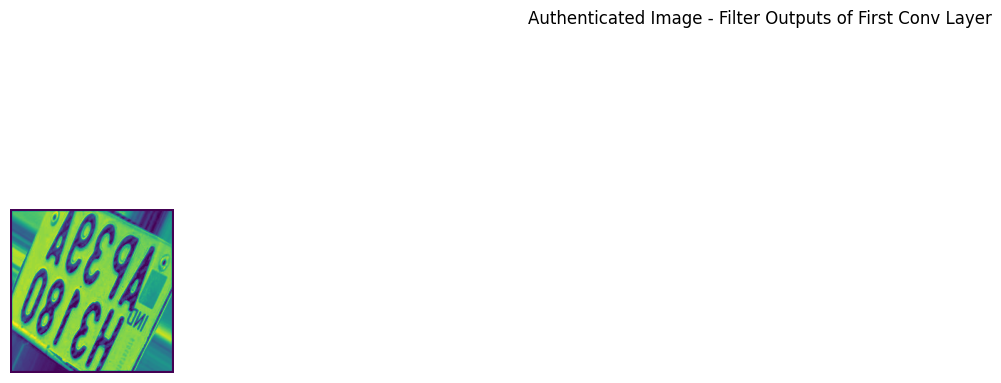

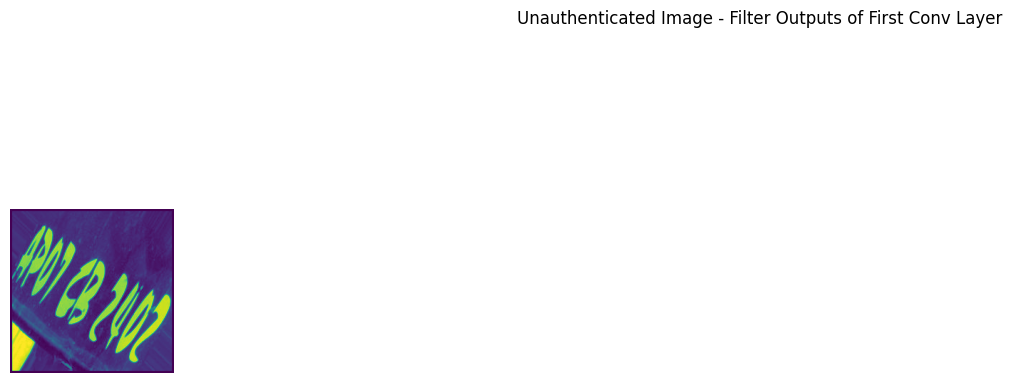

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to get the outputs of the intermediate layers
def get_intermediate_layer_outputs(model, layer_names, input_image):
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    return activation_model.predict(input_image)

# Get the names of convolutional layers from ResNet-50
conv_layer_names = [layer.name for layer in base_model.layers if 'conv' in layer.name]

# Get an authenticated image and an unauthenticated image from your dataset
# Assuming X_test contains normalized images
input_image_auth = np.expand_dims(X_test[0], axis=0)  # Example for an authenticated image
input_image_unauth = np.expand_dims(X_test[1], axis=0)  # Example for an unauthenticated image

# Get the filter outputs for authenticated image
auth_activations = get_intermediate_layer_outputs(base_model, conv_layer_names, input_image_auth)

# Get the filter outputs for unauthenticated image
unauth_activations = get_intermediate_layer_outputs(base_model, conv_layer_names, input_image_unauth)

# Visualize filter outputs (for first convolutional layer)
layer_activation = auth_activations[0]  # Activations of the first conv layer for authenticated image
num_filters = layer_activation.shape[-1]

# Plot the filters for authenticated image
plt.figure(figsize=(20, 20))
for i in range(num_filters-2):
    plt.subplot(8, 8, i + 1)
    plt.imshow(layer_activation[0, :, :, i], cmap='viridis')  # Visualize each filter
    plt.axis('off')
plt.suptitle('Authenticated Image - Filter Outputs of First Conv Layer')
plt.show()

# Plot the filters for unauthenticated image
layer_activation = unauth_activations[0]  # Activations of the first conv layer for unauthenticated image
plt.figure(figsize=(20, 20))
for i in range(num_filters-2):
    plt.subplot(8, 8, i + 1)
    plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Unauthenticated Image - Filter Outputs of First Conv Layer')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to get the outputs of intermediate layers
def get_intermediate_layer_outputs(model, layer_names, input_image):
    # Get the outputs of the specific intermediate layers
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    return activation_model.predict(input_image)

# Identify the intermediate layer names (from ResNet-50)
# Here we're selecting convolutional layers from middle of the model
conv_layer_names = ['conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']  # Example middle layers

# Get an authenticated and unauthenticated image from your dataset
# Assuming X_test contains normalized images
input_image_auth = np.expand_dims(X_test[0], axis=0)  # Example for an authenticated image
input_image_unauth = np.expand_dims(X_test[1], axis=0)  # Example for an unauthenticated image

# Get the filter outputs for authenticated image
auth_activations = get_intermediate_layer_outputs(base_model, conv_layer_names, input_image_auth)

# Get the filter outputs for unauthenticated image
unauth_activations = get_intermediate_layer_outputs(base_model, conv_layer_names, input_image_unauth)

# Visualize filter outputs for authenticated image from an intermediate layer (e.g., conv2_block3_out)
layer_activation = auth_activations[0]  # Activations of conv2_block3_out for authenticated image
num_filters = layer_activation.shape[-1]

# Plot the filters for authenticated image (from conv2_block3_out)
plt.figure(figsize=(20, 20))
for i in range(min(num_filters, 64)):  # Show 64 filters for visualization
    plt.subplot(8, 8, i + 1)
    plt.imshow(layer_activation[0, :, :, i], cmap='viridis')  # Visualize each filter
    plt.axis('off')
plt.suptitle('Authenticated Image - Filter Outputs of conv2_block3_out')
plt.show()

# Visualize filter outputs for unauthenticated image from the same intermediate layer
layer_activation = unauth_activations[0]  # Activations of conv2_block3_out for unauthenticated image
plt.figure(figsize=(20, 20))
for i in range(min(num_filters, 64)):
    plt.subplot(8, 8, i + 1)
    plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Unauthenticated Image - Filter Outputs of conv2_block3_out')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [12]:
import tensorflow as tf

# Load the model saved as resnet50_authentication_model.keras
model = tf.keras.models.load_model('resnet50_authentication_model.keras')


ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_1290>, <KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_1291>]

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a test image
img_path = '/content/authenticated/informate/dr_0_1203.jpg'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image (same as during training)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array.astype('float32') / 255.0

# Predict using the loaded model
prediction = model.predict(img_array)

# Output the result based on binary classification
if prediction < 0.5:
    print("Unauthenticated")
else:
    print("Authenticated")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Authenticated


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


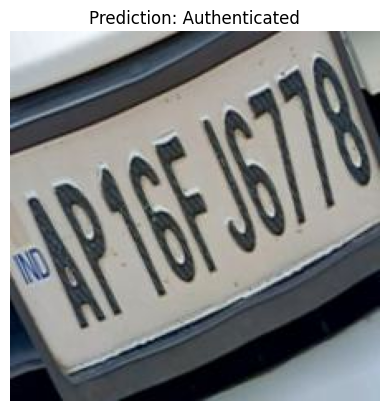

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model('resnet50_authentication_model.keras')

# Load and preprocess the test image
img_path = '/content/authenticated/informate/dr_31_6770.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

# Make prediction using the model
prediction = model.predict(img_array)

# Determine the label
label = "Authenticated" if prediction >= 0.5 else "Unauthenticated"

# Display the image with the prediction label
plt.imshow(image.load_img(img_path))
plt.title(f'Prediction: {label}')
plt.axis('off')  # Hide axis
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


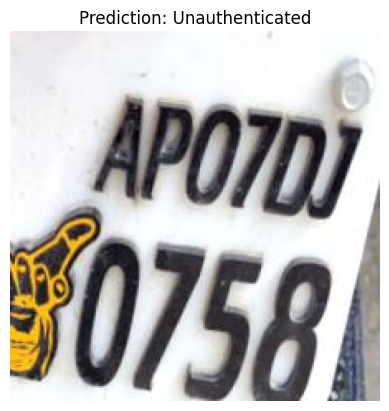

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model('resnet50_authentication_model.keras')

# Load and preprocess the test image
img_path = '/content/unauthenticated/unformate/dr_0_2035.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

# Make prediction using the model
prediction = model.predict(img_array)

# Determine the label
label = "Authenticated" if prediction >= 0.5 else "Unauthenticated"

# Display the image with the prediction label
plt.imshow(image.load_img(img_path))
plt.title(f'Prediction: {label}')
plt.axis('off')  # Hide axis
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


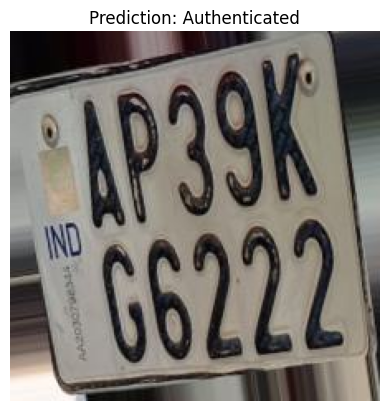

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model('resnet50_authentication_model.keras')

# Load and preprocess the test image
img_path = '/content/authenticated/informate/dr_37_2616.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

# Make prediction using the model
prediction = model.predict(img_array)

# Determine the label
label = "Authenticated" if prediction >= 0.5 else "Unauthenticated"

# Display the image with the prediction label
plt.imshow(image.load_img(img_path))
plt.title(f'Prediction: {label}')
plt.axis('off')  # Hide axis
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


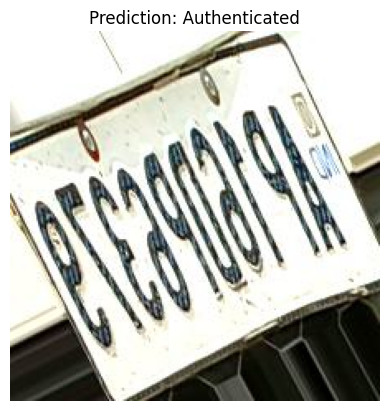

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model('resnet50_authentication_model.keras')

# Load and preprocess the test image
img_path = '/content/authenticated/informate/dr_30_4862.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

# Make prediction using the model
prediction = model.predict(img_array)

# Determine the label
label = "Authenticated" if prediction >= 0.5 else "Unauthenticated"

# Display the image with the prediction label
plt.imshow(image.load_img(img_path))
plt.title(f'Prediction: {label}')
plt.axis('off')  # Hide axis
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


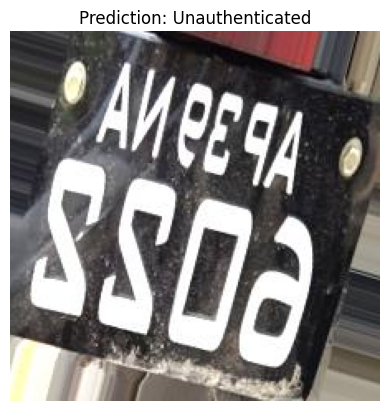

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model('resnet50_authentication_model.keras')

# Load and preprocess the test image
img_path = '/content/unauthenticated/unformate/dr_11_338.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

# Make prediction using the model
prediction = model.predict(img_array)

# Determine the label
label = "Authenticated" if prediction >= 0.5 else "Unauthenticated"

# Display the image with the prediction label
plt.imshow(image.load_img(img_path))
plt.title(f'Prediction: {label}')
plt.axis('off')  # Hide axis
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


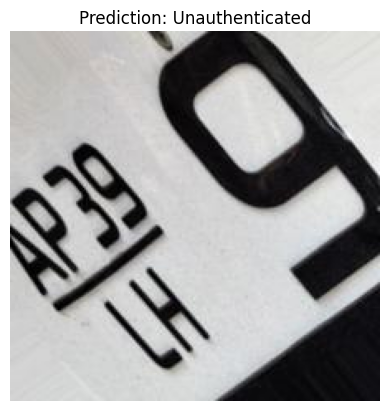

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model('resnet50_authentication_model.keras')

# Load and preprocess the test image
img_path = '/content/unauthenticated/unformate/dr_15_4743.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Normalize the image
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

# Make prediction using the model
prediction = model.predict(img_array)

# Determine the label
label = "Authenticated" if prediction >= 0.5 else "Unauthenticated"

# Display the image with the prediction label
plt.imshow(image.load_img(img_path))
plt.title(f'Prediction: {label}')
plt.axis('off')  # Hide axis
plt.show()
